# Bayesian Regression - Inference Algorithms (Part 2)

In [Part I](bayesian_regression.ipynb), we looked at how to perform inference on a simple Bayesian linear regression model using SVI.  In this tutorial, we'll explore more expressive guides as well as exact inference techniques.  We'll use the same dataset as before.

In [1]:
from __future__ import absolute_import, division, print_function

from functools import partial
import logging
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions.util import logsumexp
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO
from pyro.infer.abstract_infer import TracePredictive
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
import pyro.poutine as poutine

assert pyro.__version__.startswith('0.3.0')

In [2]:
%matplotlib inline
logging.basicConfig(format='%(message)s', level=logging.INFO)
# Enable validation checks
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)
DATA_URL = "https://d2fefpcigoriu7.cloudfront.net/datasets/rugged_data.csv"
rugged_data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")

## Bayesian Linear Regression

Our goal is once again to predict log GDP per capita of a nation as a function of two features from the dataset - whether the nation is in Africa, and its Terrain Ruggedness Index, but we will explore more expressive guides.

## Model + Guide

We will write out the model again, similar to that in [Part I](bayesian_regression.ipynb), but explicitly without the use of `nn.Module`.  We will write out each term in the regression, using the same priors. `bA` and `bR` are regression coefficients corresponding to  `is_cont_africa` and `ruggedness`, `a` is the intercept, and `bAR` is the correlating factor between the two features.

Writing down a guide will proceed in close analogy to the construction of our model, with the key difference that the guide parameters need to be trainable. To do this we register the guide parameters in the ParamStore using `pyro.param()`. Note the positive constraints on scale parameters.

In [3]:
def model(is_cont_africa, ruggedness, log_gdp):
    a = pyro.sample("a", dist.Normal(8., 1000.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    with pyro.iarange("data", len(ruggedness)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)
        
def guide(is_cont_africa, ruggedness, log_gdp):
    a_loc = pyro.param('a_loc', torch.tensor(0.))
    a_scale = pyro.param('a_scale', torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.),
                             constraint=constraints.positive)
    weights_loc = pyro.param('weights_loc', torch.randn(3))
    weights_scale = pyro.param('weights_scale', torch.ones(3),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

In [4]:
# Utility function
def summary(traces, sites):
    marginal = EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        marginal_site = pd.DataFrame(marginal[:, i]).transpose()
        describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
        site_stats[site_name] = marginal_site.apply(describe, axis=1) \
            [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

# Prepare training data
df = rugged_data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
train = torch.tensor(df.values, dtype=torch.float)

## SVI

As before, we will use SVI to perform inference.

In [5]:
svi = SVI(model, 
          guide, 
          optim.Adam({"lr": .005}), 
          loss=Trace_ELBO(), 
          num_samples=1000)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]
pyro.clear_param_store()
num_iters = 8000 if not smoke_test else 2
for i in range(num_iters):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 5800.070857703686
Elbo loss: 628.4037374258041
Elbo loss: 580.5144180059433
Elbo loss: 559.3133664131165
Elbo loss: 475.76387599110603
Elbo loss: 483.09800106287
Elbo loss: 463.2627730369568
Elbo loss: 431.5990067124367
Elbo loss: 404.8111544251442
Elbo loss: 371.7402448654175
Elbo loss: 306.60169237852097
Elbo loss: 286.20131355524063
Elbo loss: 259.70689755678177
Elbo loss: 250.59875017404556
Elbo loss: 254.11627012491226
Elbo loss: 252.16994631290436


In [6]:
svi_diagnorm_posterior = svi.run(log_gdp, is_cont_africa, ruggedness)

Let us observe the posterior distribution over the different latent variables in the model.

In [7]:
sites = ["a", "bA", "bR", "bAR", "sigma"]

for site, values in summary(svi_diagnorm_posterior, sites).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std        5%       25%      50%       75%       95%
0  9.201031  0.082693  9.069252  9.147532  9.19815  9.252062  9.341837 

Site: bA
       mean       std        5%       25%       50%      75%       95%
0 -1.802036  0.134565 -2.021231 -1.898413 -1.807264 -1.71605 -1.575664 

Site: bR
       mean      std        5%       25%       50%       75%       95%
0 -0.171068  0.04753 -0.251084 -0.204082 -0.170505 -0.138484 -0.093576 

Site: bAR
       mean       std        5%      25%       50%      75%       95%
0  0.373914  0.082028  0.240475  0.31524  0.374232  0.43036  0.504412 

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.952945  0.048892  0.876614  0.921292  0.952167  0.983158  1.036316 



## HMC

In contrast to using variational inference which gives us an approximate posterior over our latent variables, we can also do exact inference using [Markov Chain Monte Carlo](http://docs.pyro.ai/en/dev/mcmc.html) (MCMC), a class of algorithms that in the limit, allow us to draw unbiased samples from the true posterior. The algorithm that we will be using is called the No-U Turn Sampler (NUTS) \[1\], which provides an efficient and automated way of running Hamiltonian Monte Carlo.  It is slightly slower than variational inference, but provides an exact estimate.

In [8]:
nuts_kernel = NUTS(model, adapt_step_size=True)

hmc_posterior = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200) \
    .run(is_cont_africa, ruggedness, log_gdp)

In [9]:
for site, values in summary(hmc_posterior, sites).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std        5%       25%       50%       75%       95%
0  9.187324  0.138029  8.953644  9.090484  9.191498  9.282197  9.415926 

Site: bA
       mean       std        5%       25%       50%       75%       95%
0 -1.845455  0.227408 -2.243472 -1.985775 -1.846355 -1.694642 -1.451345 

Site: bR
       mean       std        5%       25%       50%      75%       95%
0 -0.186864  0.076814 -0.310594 -0.238113 -0.186715 -0.13447 -0.060283 

Site: bAR
       mean       std        5%       25%       50%       75%       95%
0  0.349127  0.132638  0.123123  0.258823  0.353356  0.437964  0.552352 

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.953111  0.053052  0.870771  0.917283  0.949017  0.986648  1.049277 



## Comparing Posterior Distributions

Let us compare the posterior distribution of the latent variables that we obtained from variational inference with those from Hamiltonian Monte Carlo. As can be seen below, for Variational Inference, the marginal distribution of the different regression coefficients is under-dispersed w.r.t. the true posterior (from HMC). This is an artifact of the *KL(q||p)* loss (the KL divergence of the true posterior from the approximate posterior) that is minimized by Variational Inference.

This can be better seen when we plot different cross sections from the joint posterior distribution overlaid with the approximate posterior from variational inference. Note that since our variational family has diagonal covariance, we cannot model any correlation between the latents and the resulting approximation is overconfident (under-dispersed)

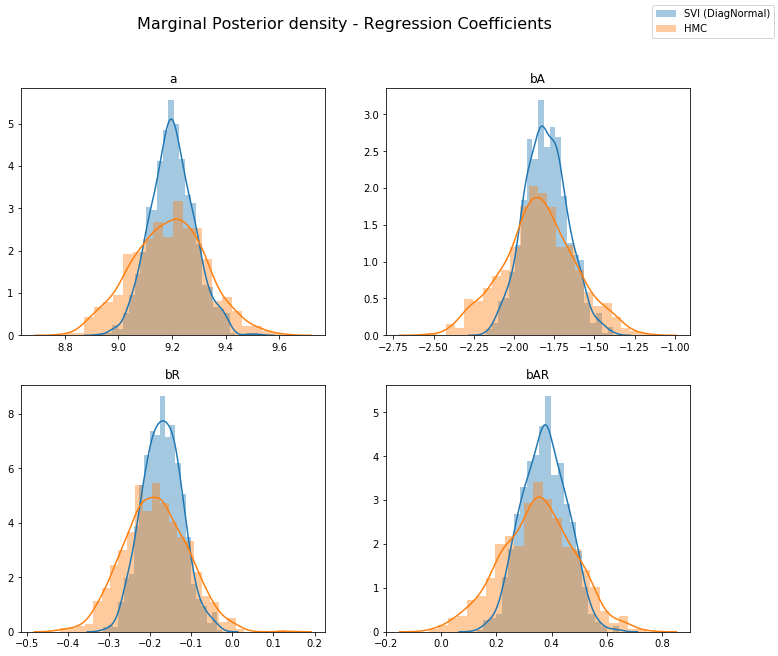

In [10]:
svi_diagnorm_empirical = EmpiricalMarginal(svi_diagnorm_posterior, sites=sites) \
                         ._get_samples_and_weights()[0] \
                         .detach().cpu().numpy()
hmc_empirical = EmpiricalMarginal(hmc_posterior, sites=sites)._get_samples_and_weights()[0].numpy()
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    sns.distplot(svi_diagnorm_empirical[:, i], ax=ax, label="SVI (DiagNormal)")
    sns.distplot(hmc_empirical[:, i], ax=ax, label="HMC")
    ax.set_title(sites[i])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

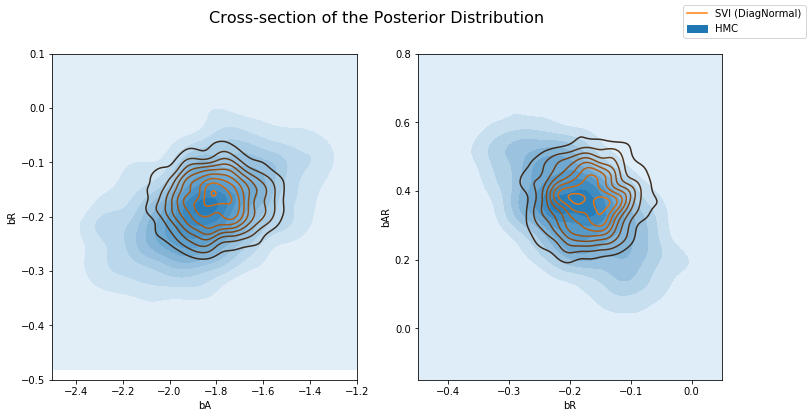

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-section of the Posterior Distribution", fontsize=16)
sns.kdeplot(hmc_empirical[:, 1], hmc_empirical[:, 2], ax=axs[0], shade=True, label="HMC")
sns.kdeplot(svi_diagnorm_empirical[:, 1], svi_diagnorm_empirical[:, 2], ax=axs[0], label="SVI (DiagNormal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(hmc_empirical[:, 2], hmc_empirical[:, 3], ax=axs[1], shade=True, label="HMC")
sns.kdeplot(svi_diagnorm_empirical[:, 2], svi_diagnorm_empirical[:, 3], ax=axs[1], label="SVI (DiagNormal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

## MultivariateNormal Guide

As comparison to the previously obtained results from Diagonal Normal guide, we will now use a guide that generates samples from a Cholesky factorization of a multivariate normal distribution.  This allows us to capture the correlations between the latent variables via a covariance matrix.  If we wrote this manually, we would need to combine all the latent variables so we could sample a Multivarite Normal jointly.

In [12]:
guide = AutoMultivariateNormal(model)

svi = SVI(model, 
          guide, 
          optim.Adam({"lr": .005}), 
          loss=Trace_ELBO(), 
          num_samples=1000)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]
pyro.clear_param_store()
for i in range(num_iters):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 571.0312964916229
Elbo loss: 554.6292096376419
Elbo loss: 522.1938552260399
Elbo loss: 497.2108246088028
Elbo loss: 518.4177484512329
Elbo loss: 452.42299622297287
Elbo loss: 492.90250730514526
Elbo loss: 472.3296730518341
Elbo loss: 398.4358947277069
Elbo loss: 410.0162795782089
Elbo loss: 267.7939188480377
Elbo loss: 253.1294464468956
Elbo loss: 256.14391285181046
Elbo loss: 251.53698712587357
Elbo loss: 251.73150616884232
Elbo loss: 252.90503132343292


Let's look at the shape of the posteriors again.  You can see the multivariate guide is able to capture more of the true posterior.

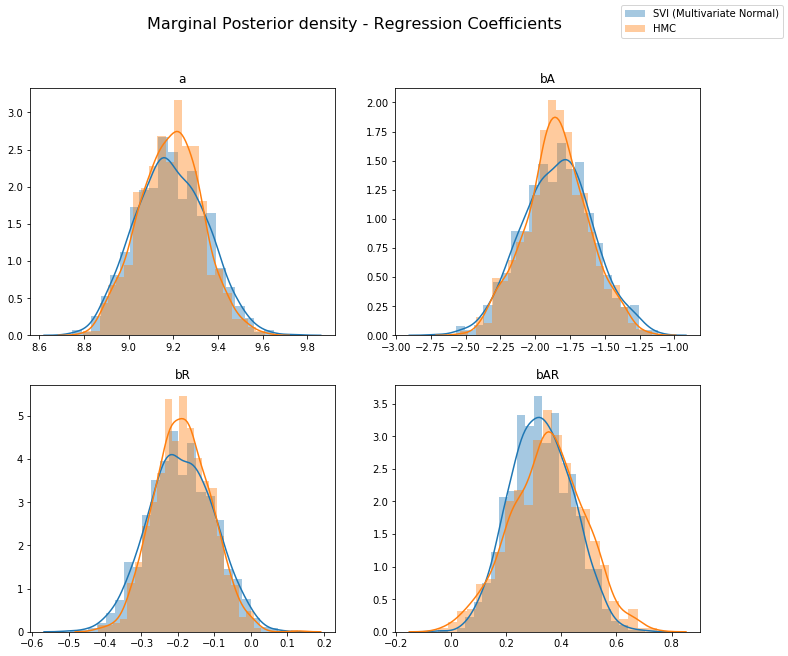

In [13]:
svi_mvn_posterior = svi.run(log_gdp, is_cont_africa, ruggedness)
svi_mvn_empirical = EmpiricalMarginal(svi_mvn_posterior, sites=sites)._get_samples_and_weights()[0] \
                    .detach().cpu().numpy()
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    sns.distplot(svi_mvn_empirical[:, i], ax=ax, label="SVI (Multivariate Normal)")
    sns.distplot(hmc_empirical[:, i], ax=ax, label="HMC")
    ax.set_title(sites[i])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

Now let's compare the posterior computed by the Diagonal Normal guide vs the Multivariate Normal guide.  Note that the multivariate distribution is more dispresed than the Diagonal Normal.

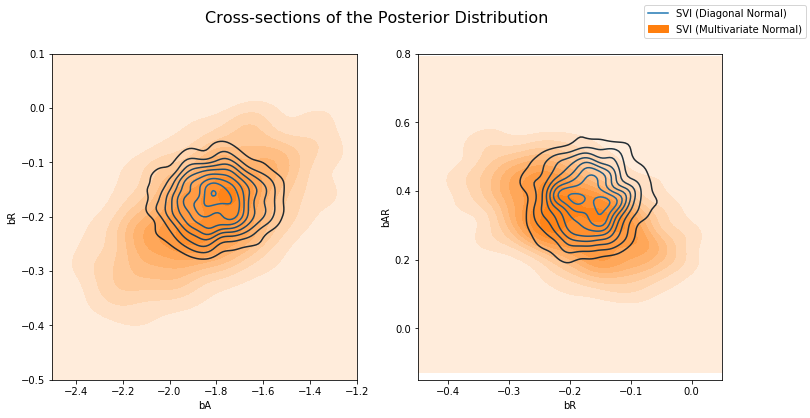

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(svi_diagnorm_empirical[:, 1], svi_diagnorm_empirical[:, 2], ax=axs[0], label="HMC")
sns.kdeplot(svi_mvn_empirical[:, 1], svi_mvn_empirical[:, 2], ax=axs[0], shade=True, label="SVI (Multivariate Normal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(svi_diagnorm_empirical[:, 2], svi_diagnorm_empirical[:, 3], ax=axs[1], label="SVI (Diagonal Normal)")
sns.kdeplot(svi_mvn_empirical[:, 2], svi_mvn_empirical[:, 3], ax=axs[1], shade=True, label="SVI (Multivariate Normal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

and the Multivariate guide with the posterior computed by HMC.  Note that the Multivariate guide better captures the true posterior.

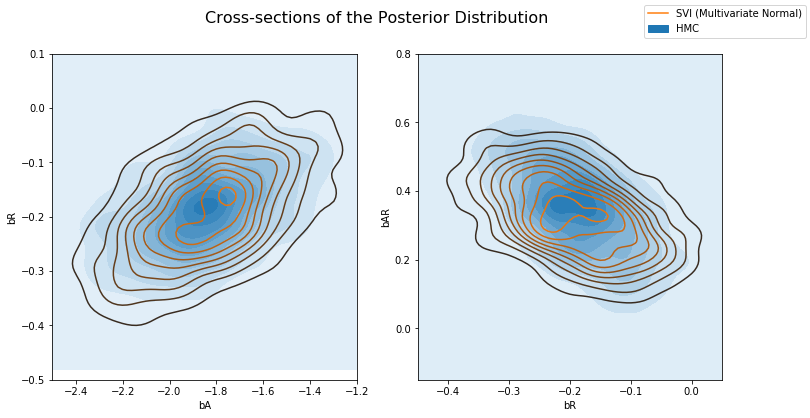

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(hmc_empirical[:, 1], hmc_empirical[:, 2], ax=axs[0], shade=True, label="HMC")
sns.kdeplot(svi_mvn_empirical[:, 1], svi_mvn_empirical[:, 2], ax=axs[0], label="SVI (Multivariate Normal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(hmc_empirical[:, 2], hmc_empirical[:, 3], ax=axs[1], shade=True, label="HMC")
sns.kdeplot(svi_mvn_empirical[:, 2], svi_mvn_empirical[:, 3], ax=axs[1], label="SVI (Multivariate Normal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

## References
[1] Hoffman, Matthew D., and Andrew Gelman. "The No-U-turn sampler: adaptively setting path lengths in Hamiltonian Monte Carlo." Journal of Machine Learning Research 15.1 (2014): 1593-1623.  https://arxiv.org/abs/1111.4246.